In [1]:
#from torch.utils.cpp_extension import load

#lltm_cpp = load(name="rrrc_cpp", sources=["rrrc.cpp"])

import os

os.system('python3 setup.py install --user')


running install


/home/artl2sch/.local/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/home/artl2sch/.local/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See

running bdist_egg
running egg_info
writing rrrc_cpp.egg-info/PKG-INFO
writing dependency_links to rrrc_cpp.egg-info/dependency_links.txt
writing top-level names to rrrc_cpp.egg-info/top_level.txt
reading manifest file 'rrrc_cpp.egg-info/SOURCES.txt'
writing manifest file 'rrrc_cpp.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_ext
building 'rrrc_cpp' extension


/home/artl2sch/.local/lib/python3.10/site-packages/torch/utils/cpp_extension.py:388: UserWarning: The detected CUDA version (11.5) has a minor version mismatch with the version that was used to compile PyTorch (11.7). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
Emitting ninja build file /home/artl2sch/Desktop/Robotic_Perception/C++/CppPython/build/temp.linux-x86_64-cpython-310/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] /bin/nvcc  -I/home/artl2sch/.local/lib/python3.10/site-packages/torch/include -I/home/artl2sch/.local/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -I/home/artl2sch/.local/lib/python3.10/site-packages/torch/include/TH -I/home/artl2sch/.local/lib/python3.10/site-packages/torch/include/THC -I/include -I/usr/include/python3.10 -c -c /home/artl2sch/Desktop/Robotic_Perception/C++/CppPython/rrrc_cuda_kernel.cu -o /home/artl2sch/Desktop/Robotic_Perception/C++/CppPython/build/temp.linux-x86_64-cpython-310/rrrc_cuda_kernel.o -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr --compiler-options ''"'"'-fPIC'"'"'' -O2 -std=c++14 -arch=sm_53 -dc -DTORCH_API_INCLUDE_EXTENSION_H '-DPYBIND11_COMPILER_TYPE="_gcc"' '-DPYBIND11_STDLIB="_libstdcpp"' '-DPYBIND11_BUILD_ABI="_cxxabi1011"' -DTORCH_EXTENSION_NAME=rrrc_cpp -D_GLIBCXX_USE_CXX11_ABI=0
/home/artl2sch/Desktop/Robotic_Percepti

zip_safe flag not set; analyzing archive contents...
__pycache__.rrrc_cpp.cpython-310: module references __file__


removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing rrrc_cpp-0.0.0-py3.10-linux-x86_64.egg
removing '/home/artl2sch/.local/lib/python3.10/site-packages/rrrc_cpp-0.0.0-py3.10-linux-x86_64.egg' (and everything under it)
creating /home/artl2sch/.local/lib/python3.10/site-packages/rrrc_cpp-0.0.0-py3.10-linux-x86_64.egg
Extracting rrrc_cpp-0.0.0-py3.10-linux-x86_64.egg to /home/artl2sch/.local/lib/python3.10/site-packages
Adding rrrc-cpp 0.0.0 to easy-install.pth file

Installed /home/artl2sch/.local/lib/python3.10/site-packages/rrrc_cpp-0.0.0-py3.10-linux-x86_64.egg
Processing dependencies for rrrc-cpp==0.0.0
Finished processing dependencies for rrrc-cpp==0.0.0


0

In [2]:
import torch
import rrrc_cpp
import time

ImportError: /home/artl2sch/.local/lib/python3.10/site-packages/rrrc_cpp-0.0.0-py3.10-linux-x86_64.egg/rrrc_cpp.cpython-310-x86_64-linux-gnu.so: undefined symbol: __cudaRegisterLinkedBinary_e38c3f53_19_rrrc_cuda_kernel_cu_27111cec

(1972, 1973)

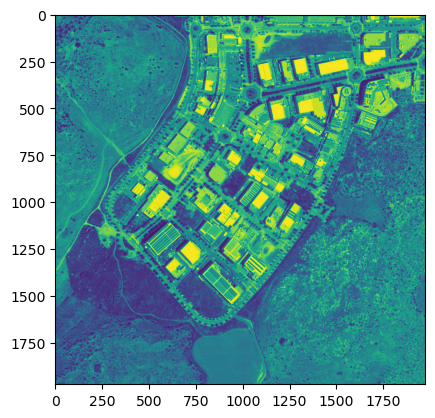

In [3]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/home/artl2sch/Desktop/Robotic_Perception/C++/FastCropRotate/0-0.png")

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#img = cv2.resize(img, [2000, 2000])

plt.imshow(img)

img.shape



In [4]:
out_n = 1000

input_image  =  torch.tensor(img, dtype = torch.uint8)[None, :, :].contiguous().cuda()
output_images = torch.zeros([out_n, 1, 128, 128], dtype = torch.float32).contiguous().cuda()

M = torch.tensor([1.0, 0.0, 0.0, 1.0]*out_n, dtype = torch.float32)
M_rand = torch.rand_like(M) - 1.0
M += M_rand * 0.5
M *= input_image.shape[-1]/output_images.shape[-1]

T = torch.tensor([0.0, 0.0]*out_n, dtype = torch.float32)
input_image.shape, output_images.shape, M

type(input_image)

torch.Tensor

In [27]:
t = time.time()
rrrc_cpp.rrrc(input_image, output_images, M, T)
print (time.time() - t)



here
1972 1973 128 128 1000
0.009504556655883789
elapsed time: 0.00230411s


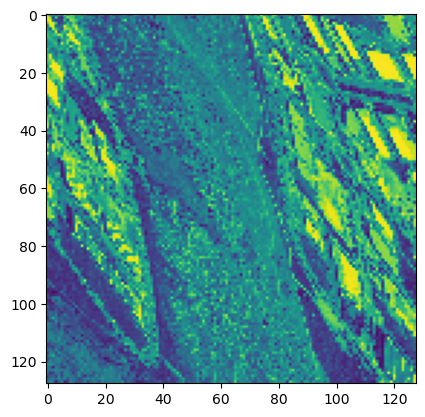

In [6]:
plt.imshow(output_images[12, 0].cpu().numpy())

In [6]:
a = torch.ones([3, 1, 10, 10])

In [9]:
ptr = a.data_ptr()